In [1]:
# https://www.kaggle.com/gpreda/santander-eda-and-prediction
# used for inspiration

# using featuretools

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sb
import lightgbm as lgb
import tensorflow as tf
import featuretools as ft
import matplotlib.pyplot as plt
# from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

In [2]:
train = pd.read_csv("train_small.csv", header=None, names=["ID_code", "target"]+["var_"+str(i) for i in range(200)])

In [3]:
test = pd.read_csv("test_small.csv")

In [62]:
train.shape, test.shape

((70057, 202), (70065, 201))

In [63]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
2,train_7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
3,train_12,8.7671,-4.6154,9.7242,7.4242,9.0254,1.4247,6.2815,12.3143,5.6964,...,0.3782,7.4382,0.0854,1.3444,17.2439,-0.0798,5.7389,8.4897,17.0938,4.6106
4,train_14,13.8080,5.0514,17.2611,8.5120,12.8517,-9.1622,5.7327,21.0517,-4.5117,...,1.0740,8.3220,3.2619,1.6738,17.4797,-0.0257,-3.5323,9.3439,24.4479,-5.1110


In [64]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
1,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
2,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
3,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
4,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097


In [26]:
train.describe()

,1,2,3,4,5,6,7,8,9,10,...,192,193,194,195,196,197,198,199,200,201
count,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,...,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000
mean,0.099733,10.678757,-1.625370,10.718501,6.801363,11.080280,-5.099666,5.412131,16.557562,0.284365,...,3.257023,7.444208,1.927193,3.328773,18.008622,-0.140578,2.298631,8.906114,15.869843,-3.323176
std,0.299646,3.037911,4.060012,2.629766,2.043351,1.627265,7.887190,0.867160,3.422813,3.335973,...,4.540336,3.018182,1.481911,3.988392,3.138089,1.427751,5.460012,0.920043,3.014017,10.438217
min,0.000000,0.597900,-15.043400,2.615000,-0.040200,5.490200,-29.777300,2.347300,5.349700,-9.905100,...,-13.999500,-2.009400,-3.566800,-11.783400,9.594900,-4.644200,-14.020400,5.960600,6.299300,-38.852800
25%,0.000000,8.461000,-4.751700,8.742600,5.252000,9.877400,-11.271800,4.768100,13.951300,-2.335100,...,-0.022800,5.161900,0.886300,0.587800,15.640500,-1.164000,-1.956100,8.253600,13.819700,-11.236200
50%,0.000000,10.526500,-1.614100,10.589100,6.837700,11.113000,-4.844100,5.387400,16.464600,0.409100,...,3.231400,7.341700,1.899100,3.387100,17.975900,-0.169000,2.390700,8.886000,15.931700,-2.800100
75%,0.000000,12.749600,1.371600,12.505900,8.333400,12.268000,0.907600,6.005500,19.119800,2.946300,...,6.410200,9.529300,2.952300,6.206400,20.421000,0.828300,6.573400,9.589400,18.071500,4.855300
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,16.806500,8.447700,27.638900,9.482200,...,18.342300,16.684600,7.611600,17.908600,27.928800,4.075600,16.226600,11.843900,26.079100,27.531900


In [27]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,...,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000
mean,10.673473,-1.636284,10.716429,6.789705,11.075697,-5.040173,5.406073,16.531615,0.287496,7.561346,...,3.192914,7.434805,1.929542,3.306963,17.985451,-0.144594,2.292337,8.913608,15.875528,-3.363418
std,3.038395,4.043325,2.645041,2.042268,1.622335,7.864192,0.867739,3.413390,3.329416,1.238668,...,4.566389,3.025254,1.478161,3.985700,3.144663,1.426939,5.442084,0.922834,3.013491,10.458007
min,0.452800,-14.696200,2.117100,0.255000,5.074800,-32.562600,2.495700,6.465300,-10.505500,4.177100,...,-13.454700,-2.343000,-3.814500,-10.828300,8.694400,-5.018500,-13.885900,6.143200,6.644800,-38.852800
25%,8.443200,-4.745900,8.718200,5.250600,9.886400,-11.161400,4.764700,13.933300,-2.306100,6.604600,...,-0.096300,5.153000,0.895000,0.563300,15.613300,-1.173900,-1.953300,8.255200,13.835100,-11.227900
50%,10.510400,-1.613400,10.580600,6.816300,11.108100,-4.820800,5.381800,16.435100,0.395100,7.619900,...,3.168000,7.346800,1.899700,3.379800,17.937000,-0.176100,2.390600,8.890100,15.950100,-2.871800
75%,12.767100,1.324400,12.523700,8.306400,12.255000,0.948800,6.003600,19.093000,2.932600,8.579700,...,6.360100,9.500200,2.951800,6.179200,20.399200,0.827700,6.524600,9.600300,18.070600,4.831400
max,19.998400,10.167100,18.412700,13.098300,15.991400,17.128100,8.285200,27.691800,10.151300,11.150600,...,18.431800,16.541100,8.402400,18.281800,27.597300,4.255700,17.684100,11.851100,26.034600,28.500700


In [28]:
# Mean of 1 (class) is 0.099, which means only 9% of classes is classified as 1

In [36]:
print(sum(train.isnull().sum()))
print(sum(test.isnull().sum()))
# no null values

0
0


In [4]:
train_values = train.values
X = train_values[:,2:]
Y = train_values[:,1]
Y = Y.astype('int')

Text(0, 0.5, 'cummulative explained variance')

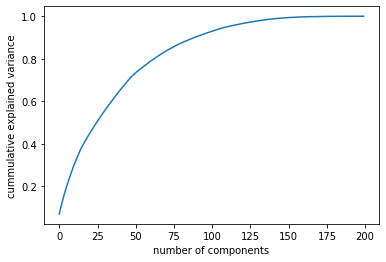

In [10]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cummulative explained variance')
# could potentially train with 50-100 less variables

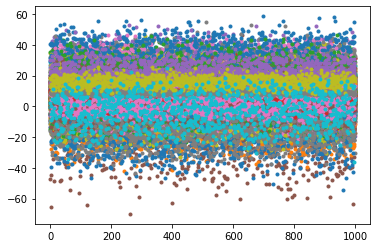

In [11]:
plt.plot(X[:1000], '.')

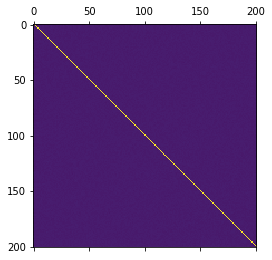

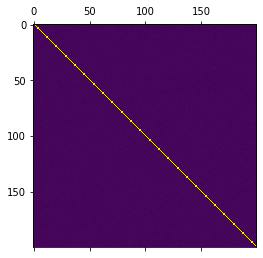

In [51]:
train_corr = train.corr()
plt.matshow(train_corr)
plt.show()
test_corr = test.corr()
plt.matshow(test_corr)
plt.show()

In [71]:
mx = -1
mn = 1
for v in train_corr.unstack():
    if v > mx and v != 1:
        mx = v
    if v < mn:
        mn = v
print(mx, mn)
# no large correlations

0.06879016056636551 -0.0809971844473954


In [102]:
def plot_feature_distribution(df1, df2, f1, f2):
    sb.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10, 20, figsize=(18,22))

    for i in range(len(f1)):
        plt.subplot(10, 20 ,i+1)
        sb.distplot(df1[f1[i]], hist=False)
        sb.distplot(df2[f2[i]], hist=False)
        plt.xlabel(f2[i], fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

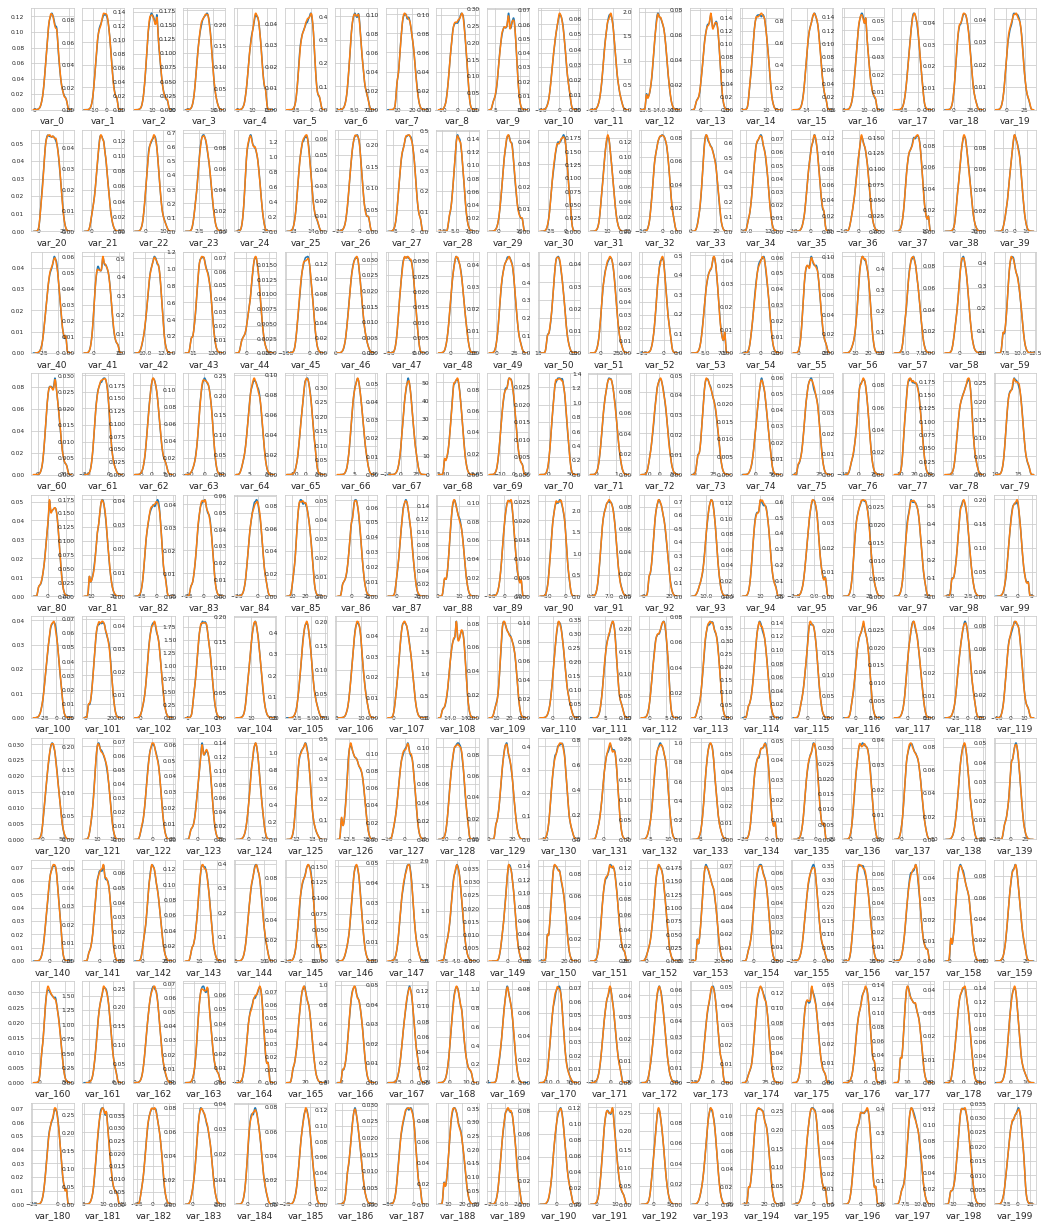

In [103]:
f1 = train.columns.values[2:202]
f2 = test.columns.values[1:201]
plot_feature_distribution(train, test, f1, f2)
# train and test data looks similar

In [89]:
# Tried to use featuretools to construct features, but worked poorly
# (Feature tools is not really designed to construct features for single tables)
train_features = [c for c in train.columns if c not in ["ID_code", "target"]]
test_features = [c for c in train.columns if c not in ["ID_code"]]

train_id = train["ID_code"]
label = train["target"]

entities = { "train" : (train, "ID_code") }
relationships = []
entities = ft.EntitySet("my-entity-set", entities, relationships)

In [99]:
# Filled in trans_primitives, but it ate all my RAM, and froze
feature_matrix, feature_names = ft.dfs(entityset=entities, target_entity = 'train', 
        trans_primitives=[], max_depth=1, verbose=1)

Built 201 features


Elapsed: 00:00 | Progress:   0%|          

Elapsed: 00:00 | Progress:   0%|          

Elapsed: 00:02 | Progress: 100%|██████████

Elapsed: 00:02 | Progress: 100%|██████████

In [6]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.10, random_state=42)

In [6]:
# check if reasonable split
print(sum(y_train)/len(y_train), sum(y_val)/len(y_val))

0.10029975733929676 0.09463317156722809


In [14]:
clf_rf = RandomForestClassifier(n_jobs=4, random_state=0)
clf_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [5]:
# check that the algorithm is not classifying everything as one class
def accuracy(y_true, y_predict):
    TP, FN, TN, FP = 0, 0, 0, 0
    for (i, y) in enumerate(y_predict):
        if y == 1:
            if y_true[i] == 1:
                # true positive
                TP += 1
            elif y_true[i] == 0:
                # false positive
                FP += 1
        elif y == 0:
            if y_true[i] == 1:
                # false negative
                FN += 1
            elif y_true[i] == 0:
                # true negative
                TN += 1
    print("positive accuracy:", TP/(TP + FN))
    print("negative accuracy:", TN/(TN + FP))
    return TP, FN, TN, FP

In [16]:
accuracy(y_val, clf_rf.predict(x_val))
roc_auc_score(y_val, clf_rf.predict(x_val))
# random forrest is shit

positive accuracy: 0.010558069381598794
negative accuracy: 0.999684691786221


0.5051213805839099

In [17]:
# kfold = model_selection.KFold(n_splits=4, random_state=0)

In [18]:
clf_ab = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ab.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [19]:
accuracy(y_val, clf_ab.predict(x_val))
roc_auc_score(y_val, clf_ab.predict(x_val))
# adaboost is better than random forrest, but still not good

positive accuracy: 0.22624434389140272
negative accuracy: 0.9862840927006149


0.6062642182960088

In [22]:
from sklearn.model_selection import GridSearchCV

lg = lgb.LGBMClassifier(silent=False)
param_dist = {'feature_fraction': [0.05, 0.1], 
              'min_data_in_leaf': [10, 50, 100, 200],
              'min_sum_hessian_in_leaf': [0.01, 0.1, 1, 10.0], 
              'num_leaves': [10, 100, 1000],
              'metric': ['auc'],
              'learning_rate': [0.01]
             }

grid_search = GridSearchCV(lg, n_jobs=1, param_grid=param_dist, cv = 2, scoring="roc_auc", verbose=5)
grid_search.fit(x_train, y_train)
grid_search.best_estimator_

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10, score=0.837, total=   2.4s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10, score=0.833, total=   2.3s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s


[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=100, score=0.822, total=   3.6s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s remaining:    0.0s


[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=100, score=0.823, total=   3.6s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=1000 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.7s remaining:    0.0s


[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=1000, score=0.734, total=  16.1s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=1000 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=1000, score=0.733, total=  15.2s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.1, num_leaves=10 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.1, num_leaves=10, score=0.837, total=   2.3s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.1, num_leaves=10 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.1, num_leaves=10, score=0.833, total=   2.5s
[CV]

[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.1, num_leaves=1000, score=0.806, total=   7.6s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.1, num_leaves=1000 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.1, num_leaves=1000, score=0.803, total=   8.0s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=1, num_leaves=10 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=1, num_leaves=10, score=0.838, total=   2.3s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=1, num_leaves=10 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=1, num_leaves=10, score=0.835, total=   2.5s
[CV] feature_fr

[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=1, num_leaves=1000, score=0.832, total=   5.7s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=1, num_leaves=1000 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=1, num_leaves=1000, score=0.825, total=   6.2s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=10.0, num_leaves=10 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=10.0, num_leaves=10, score=0.840, total=   3.7s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=10.0, num_leaves=10 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=10.0, num_leaves=10, score=0.836, total=   3.0s
[C

[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=10.0, num_leaves=1000, score=0.849, total=   3.9s
[CV] feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=10.0, num_leaves=1000 
[CV]  feature_fraction=0.05, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=10.0, num_leaves=1000, score=0.839, total=   3.8s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10, score=0.822, total=   2.5s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=10, min_sum_hessian_in_leaf=0.01, num_leaves=10, score=0.813, total=   2.5s
[

[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.01, num_leaves=1000, score=0.841, total=   9.7s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.01, num_leaves=1000 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.01, num_leaves=1000, score=0.840, total=   9.4s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.1, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.1, num_leaves=10, score=0.823, total=   2.7s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.1, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=50, min_sum_hessian_in_leaf=0.1, num_leaves=10, score=0.814, total=   2.7s
[CV] featur

[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=0.1, num_leaves=1000, score=0.852, total=   5.7s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=0.1, num_leaves=1000 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=0.1, num_leaves=1000, score=0.851, total=   5.8s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=1, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=1, num_leaves=10, score=0.824, total=   2.4s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=1, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=100, min_sum_hessian_in_leaf=1, num_leaves=10, score=0.815, total=   2.5s
[CV] feature_fr

[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=1, num_leaves=1000, score=0.856, total=   4.1s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=1, num_leaves=1000 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=1, num_leaves=1000, score=0.850, total=   4.1s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=10.0, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=10.0, num_leaves=10, score=0.826, total=   2.5s
[CV] feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=10.0, num_leaves=10 
[CV]  feature_fraction=0.1, learning_rate=0.01, metric=auc, min_data_in_leaf=200, min_sum_hessian_in_leaf=10.0, num_leaves=10, score=0.816, total=   2.4s
[CV] feat

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 16.5min finished


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.1, importance_type='split',
               learning_rate=0.01, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=200, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.01, n_estimators=100, n_jobs=-1,
               num_leaves=100, objective=None, random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [9]:
from sklearn.model_selection import GridSearchCV

lg = lgb.LGBMClassifier(silent=False)
param_dist = {'bagging_freq': [4],
              'bagging_fraction': [0.5],
              'feature_fraction': [0.1],
              'n_estimators': [1000],
              'max_depth': [-1],
              'min_data_in_leaf': [50, 100, 200],
              'min_sum_hessian_in_leaf': [0.1, 1, 10], 
              'min_gain_to_split': [0.1, 1, 10],
              'num_leaves': [10, 20, 50],
              'metric': ['auc'],
              'learning_rate': [0.01]
             }

grid_search = GridSearchCV(lg, n_jobs=1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
grid_search.fit(X, Y)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=10, score=0.869, total=   6.5s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=10, score=0.871, total=   6.3s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s


[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=10, score=0.870, total=   6.6s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s


[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.878, total=   8.5s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.2s remaining:    0.0s


[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.880, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.880, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learni

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.881, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.881, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_r

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.880, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.880, total=   8.6s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, ma

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.877, total=   6.8s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.876, total=   7.1s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_r

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.877, total=   7.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.876, total=   7.0s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=50, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=0.1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.882, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=0.1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=0.1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.881, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=0.1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_r

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.882, total=   8.3s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.881, total=   8.3s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_r

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.882, total=   8.7s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.881, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=10, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.877, total=   6.8s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=10, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=10, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.876, total=   6.8s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=100, min_gain_to_split=10, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.883, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.883, total=   8.3s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, le

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.883, total=   8.3s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.883, total=   8.3s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=0.1, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learni

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.883, total=   8.2s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=20, score=0.883, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=1, min_sum_hessian_in_leaf=1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.877, total=   8.4s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=20, score=0.876, total=   8.2s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=0.1, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learni

[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.877, total=   6.7s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=20, score=0.876, total=   6.7s
[CV] bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_rate=0.01, max_depth=-1, metric=auc, min_data_in_leaf=200, min_gain_to_split=10, min_sum_hessian_in_leaf=10, n_estimators=1000, num_leaves=50 
[CV]  bagging_fraction=0.5, bagging_freq=4, feature_fraction=0.1, learning_r

[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 35.0min finished


LGBMClassifier(bagging_fraction=0.5, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.1,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=50, min_gain_to_split=1, min_split_gain=0.0,
               min_sum_hessian_in_leaf=10, n_estimators=1000, n_jobs=-1,
               num_leaves=50, objective=None, random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=False, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [23]:
param = {
    'bagging_freq': 4,
    'bagging_fraction': 0.5,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.1,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc', 
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 10,
    'num_leaves': 50,
    'min_gain_to_split': 1,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}

In [81]:
features = [c for c in train.columns if c not in [0, 1]]
train_data, val_data = np.split(train.sample(frac=1), [int(.9*len(train))])
# check if split is decent
print(sum(train_data[1])/len(train_data), sum(val_data[1])/len(val_data))

# using lightbm over catboost because no categorical features
train_data = lgb.Dataset(train_data[features], label=train_data[1])
val_data = lgb.Dataset(val_data[features], label=val_data[1])
clf = lgb.train(param, train_data, 100000, valid_sets = [train_data, val_data], verbose_eval=1000, early_stopping_rounds = 4000)

0.09907852373475441 0.10562375107051099
Training until validation scores don't improve for 4000 rounds.
[1000]	training's auc: 0.91963	valid_1's auc: 0.880865
[2000]	training's auc: 0.942784	valid_1's auc: 0.893767
[3000]	training's auc: 0.957128	valid_1's auc: 0.897484
[4000]	training's auc: 0.967318	valid_1's auc: 0.898922
[5000]	training's auc: 0.975301	valid_1's auc: 0.899645
[6000]	training's auc: 0.981633	valid_1's auc: 0.899512
[7000]	training's auc: 0.986809	valid_1's auc: 0.899443
[8000]	training's auc: 0.990682	valid_1's auc: 0.898909
[9000]	training's auc: 0.99363	valid_1's auc: 0.898294
Early stopping, best iteration is:
[5909]	training's auc: 0.981051	valid_1's auc: 0.899754


In [82]:
import math
train_predict = clf.predict(train[features], num_iteration=clf.best_iteration)
predictions = list(map(lambda x : math.floor(x+0.5), train_predict))
print(accuracy(Y, predictions))
print(roc_auc_score(Y, predictions))

test_features = [c for c in test.columns if c not in ["ID_code"]]
predict = clf.predict(test[test_features], num_iteration=clf.best_iteration)
# prediction gives probability of target being 1
# test set proably has the same target distribution as training set
predictions = list(map(lambda x : math.floor(x+0.5), predict))
print("test_target_1_percentage:", sum(predictions)/len(predictions))

positive accuracy: 0.5415772148275368
negative accuracy: 0.9977802441731409
(3784, 3203, 62930, 140)
0.7696787295003389
test_target_1_percentage: 0.037293941340184114


In [11]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, Y_resampled = ros.fit_resample(x_train, y_train)
# works better than no resampling

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_val_minmax = min_max_scaler.fit_transform(x_val)

In [50]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=[200]))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_40 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_43 (Dense)             (None, 32)               

In [51]:
class_weight = {0: 1., 1: 10}
print(x_train_minmax.shape, y_train.shape)
targets = np.array(y_train).reshape(-1)
one_hot_targets = np.eye(2)[targets]
model.fit(x_train_minmax, one_hot_targets, batch_size=512, class_weight=class_weight, epochs=100, validation_split=0.1)

(63051, 200) (63051,)
Train on 56745 samples, validate on 6306 samples
Epoch 1/100
56745/56745 [==============================] - 2s 28us/sample - loss: 1.2268 - val_loss: 1.1495
Epoch 2/100
56745/56745 [==============================] - 1s 10us/sample - loss: 1.0151 - val_loss: 0.9721
Epoch 3/100
56745/56745 [==============================] - 1s 9us/sample - loss: 0.9659 - val_loss: 0.9174
Epoch 4/100
56745/56745 [==============================] - 1s 10us/sample - loss: 0.9210 - val_loss: 0.9811
Epoch 5/100
56745/56745 [==============================] - 1s 10us/sample - loss: 0.9175 - val_loss: 0.8958
Epoch 6/100
56745/56745 [==============================] - 1s 9us/sample - loss: 0.9206 - val_loss: 0.9023
Epoch 7/100
56745/56745 [==============================] - 1s 10us/sample - loss: 0.9042 - val_loss: 0.8999
Epoch 8/100
56745/56745 [==============================] - 1s 9us/sample - loss: 0.9072 - val_loss: 0.8950
Epoch 9/100
56745/56745 [==============================] - 0s 9us/sa

56745/56745 [==============================] - 0s 9us/sample - loss: 0.7124 - val_loss: 1.1464
Epoch 77/100
56745/56745 [==============================] - 0s 8us/sample - loss: 0.7153 - val_loss: 1.1717
Epoch 78/100
56745/56745 [==============================] - 0s 8us/sample - loss: 0.7054 - val_loss: 1.2384
Epoch 79/100
56745/56745 [==============================] - 0s 8us/sample - loss: 0.6997 - val_loss: 1.2820
Epoch 80/100
56745/56745 [==============================] - 0s 9us/sample - loss: 0.7218 - val_loss: 1.3104
Epoch 81/100
56745/56745 [==============================] - 0s 9us/sample - loss: 0.6942 - val_loss: 1.1283
Epoch 82/100
56745/56745 [==============================] - 0s 8us/sample - loss: 0.7014 - val_loss: 1.1634
Epoch 83/100
56745/56745 [==============================] - 0s 9us/sample - loss: 0.7002 - val_loss: 1.3244
Epoch 84/100
56745/56745 [==============================] - 0s 8us/sample - loss: 0.6731 - val_loss: 1.3748
Epoch 85/100
56745/56745 [===============

In [52]:
predictions = list(map(lambda x : np.argmax(x), model.predict(x_val_minmax)))
print(accuracy(y_val, predictions))
print(roc_auc_score(y_val, predictions))

positive accuracy: 0.7541478129713424
negative accuracy: 0.7526407062903989
(500, 163, 4774, 1569)
0.7533942596308705


In [56]:
# get output from last hidden layer
last_hidden_output = tf.keras.backend.function([model.layers[0].input], [model.layers[-2].output])
# last_output = tf.keras.backend.function([model.layers[0].input], [model.layers[-1].output])

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
train_with_network_features = train.copy()
for i, row in enumerate(np.array(last_hidden_output(x_scaled)).T):
    train_with_network_features[("var_"+str(i+200))] = row
# for i, row in enumerate(np.array(last_output(x_scaled)).T):
#    train_with_network_features[("var_"+str(i+232))] = row

print(train_with_network_features.head())

   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
1  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
2  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   
3  train_5       0  11.4763 -2.3182  12.6080  8.6264  10.9621  3.5609  4.5322   
4  train_6       0  11.8091 -0.0832   9.3494  4.2916  11.1355 -8.0198  6.1961   

     var_7  ...   var_222   var_223   var_224   var_225  var_226   var_227  \
0  16.5338  ...  1.779131  0.140360  1.764648 -0.000000     -0.0 -0.000000   
1  14.6155  ... -0.000000 -0.000000  0.028420  1.604927     -0.0  1.859279   
2  19.2514  ...  0.161774 -0.000000  0.188128  0.494436     -0.0  0.550706   
3  15.2255  ... -0.000000 -0.000000  0.017359  3.295378     -0.0  4.077375   
4  12.0771  ...  0.619248  0.059759  0.606202 -0.000000     -0.0  0.055091   

    var_228   var_229   var_230   var_231  


In [57]:
features = [c for c in train_with_network_features.columns if c not in ["ID_code", "target"]]
train_data, val_data = np.split(train_with_network_features.sample(frac=1), [int(.9*len(train_with_network_features))])
# check if split is decent
print(sum(train_data["target"])/len(train_data), sum(val_data["target"])/len(val_data))

# using lightbm over catboost because no categorical features
train_data = lgb.Dataset(train_data[features], label=train_data["target"])
val_data = lgb.Dataset(val_data[features], label=val_data["target"])
clf = lgb.train(param, train_data, 4000, valid_sets = [train_data, val_data], verbose_eval=500)

0.10015701574915545 0.0959177847559235
[500]	training's auc: 0.949874	valid_1's auc: 0.92696
[1000]	training's auc: 0.971479	valid_1's auc: 0.931619
[1500]	training's auc: 0.98426	valid_1's auc: 0.933449
[2000]	training's auc: 0.991488	valid_1's auc: 0.934202
[2500]	training's auc: 0.995765	valid_1's auc: 0.93487
[3000]	training's auc: 0.997934	valid_1's auc: 0.935341
[3500]	training's auc: 0.999008	valid_1's auc: 0.935247
[4000]	training's auc: 0.999453	valid_1's auc: 0.935241


In [58]:
import math
train_predict = clf.predict(train_with_network_features[features], num_iteration=clf.best_iteration)
predictions = list(map(lambda x : math.floor(x+0.5), train_predict))
print(accuracy(Y, predictions))
print(roc_auc_score(Y, predictions))

positive accuracy: 0.8900815800772864
negative accuracy: 0.9978278103694308
(6219, 768, 62933, 137)
0.9439546952233587
